In [2]:
from pathlib import Path
import glob
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.lines import Line2D

import scienceplots


SINGLE_COL_WIDTH = 3.5
DOUBLE_COL_WIDTH = 7.16
DPI = 150

plt.style.use(["science", "ieee"])
plt.rcParams.update({
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

ref_style = {
    "linestyle": "--",
    "color": "black",
    "alpha": 0.7,
    "linewidth": 1.0,
    "label": "ED Reference",
}

# use the color palette manually, since importing seaborn overrides the paper styles
SB_COLORBLIND = [
    "#0173b2",
    "#de8f05",
    "#029e73",
    "#d55e00",
    "#cc78bc",
    "#ca9161",
    "#fbafe4",
    "#949494",
    "#ece133",
    "#56b4e9",
]

main_style = {
    "linestyle": "-",
    "linewidth": 1.0,
    "alpha": 0.9,
    "marker": "o",
    "markersize": 3,
    "markeredgewidth": 0.0,
    "color": SB_COLORBLIND[0],
}

SUPPORT_GUIDE_LS = (0, (1.5, 2.8))  # a bit finer than (2,2)
SUPPORT_GUIDE_LW = 0.75            # thinner
SUPPORT_GUIDE_A  = 0.30            # more transparent
SUPPORT_GUIDE_C  = "0.20"          # slightly lighter gray
SUPPORT_LABEL_A  = 1.0
SUPPORT_LABEL_T = r"Support $g$"

print("Global styles defined.")

Global styles defined.


In [3]:
# --- Data Config ---
CHAIN_LENGTH = 16
DATA_FILE = Path("tfim_l16_entangle_rbm_20251212_030007.csv")
REF_FILE = Path(f"tfim_{CHAIN_LENGTH}_entropy_ref.csv")

# --- Load & Process ---
if DATA_FILE.exists():
    df_res = pd.read_csv(DATA_FILE)
    ref_df_2 = pd.read_csv(REF_FILE) if REF_FILE.exists() else pd.DataFrame()

    # Pivot for 3D Surface
    pivot_df = df_res.pivot(index="l", columns="h", values="s2")

    # Meshgrid Construction
    h_dense = pivot_df.columns.values.astype(float)
    l_values = pivot_df.index.values.astype(int)
    X_h, Y_l = np.meshgrid(h_dense, l_values)
    Z_s2 = pivot_df.values

    # Find support cuts
    support_h_keys = np.sort(
        df_res[df_res["type"] == "support"]["h"].unique()
    )

    if not ref_df_2.empty:
        ref_df_2["h"] = ref_df_2["h"].astype(float)

    print(f"Data Loaded. Cuts at h={support_h_keys}")
else:
    print("Error: Main data file not found.")
    df_res, pivot_df, X_h, Y_l, Z_s2, support_h_keys = None, None, None, None, None, []
    ref_df_2 = pd.DataFrame()

Data Loaded. Cuts at h=[0.5  0.8  0.95 1.   1.05 1.2  1.5 ]


Saved: tfim_4x4_entropy.pdf


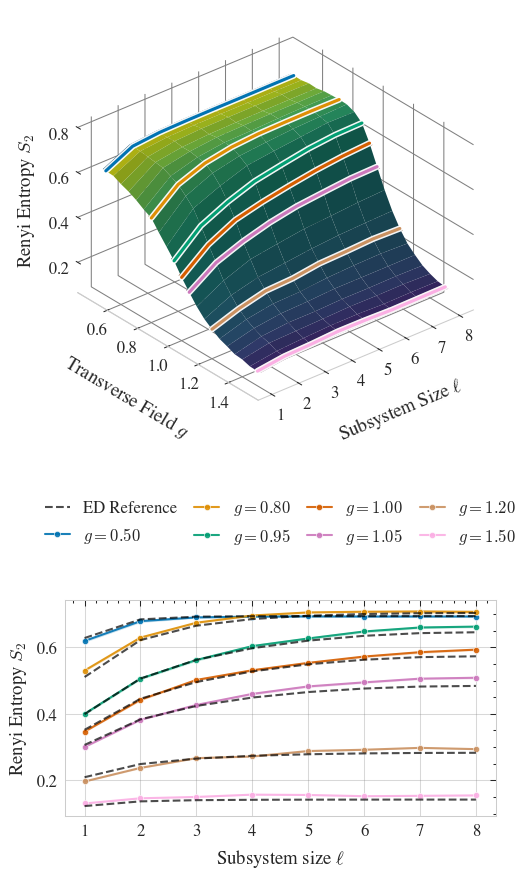

In [5]:
# --- Configuration ---
SAVE_FIG = True
FILENAME = "tfim_4x4_entropy.pdf"
COLUMN_MODE = "single"          # "single" or "double"
SAVE_TIGHT = False              # keep False while tuning

# ==========================================================
# FONT SIZES (separate knobs)
# ==========================================================
TEXT_SIZE = 9                   # axis labels + z-label text
TICK_LABEL_SIZE = 8             # tick numbers (2D + 3D)
LEGEND_SIZE = 8                 # legend text
PANEL_LABEL_SIZE = 12           # (kept for compatibility; panel indices removed)

# ==========================================================
# 3D KNOBS
# ==========================================================
THREE_D_RATIO = 2.0
TWO_D_RATIO   = 1.0

# Vertical spacing between 3D (top) and 2D (bottom)
VERTICAL_GAP = 0.50             # larger -> more separation

SHIFT_3D_X = -0.02              # + right, - left

BOX_ASPECT_X = 1.0
BOX_ASPECT_Y = 1.0
BOX_ASPECT_Z = 0.7

XTICK_PAD = -3                  # apply AFTER draw
YTICK_PAD = -3
ZTICK_PAD = -3

X_LABEL_SPACE = 0.0             # mplot3d private spacing knob
Y_LABEL_SPACE = 0.0
X_LABELPAD = 0
Y_LABELPAD = 0

ZLABEL_X = -0.04                # manual z-label position (axes fraction)
ZLABEL_Y = 0.55
ZLABEL_ROT = 90

# ==========================================================
# 2D KNOBS
# ==========================================================
LEGEND_NCOL = 4
LEGEND_ANCHOR = (0.5, 1.22)     # centered ABOVE the 2D axes
LEGEND_LOC = "lower center"

# ==========================================================
# Figure margins
# ==========================================================
LEFT_MARGIN   = 0.16
RIGHT_MARGIN  = 0.98
TOP_MARGIN    = 0.98
BOTTOM_MARGIN = 0.08

FIELD_SYMBOL = "g"              # display-only symbol (data stays named "h")

def _apply_3d_label_spacing(ax, x_space, y_space, x_pad, y_pad):
    ax.xaxis._axinfo["label"]["space_factor"] = x_space
    ax.yaxis._axinfo["label"]["space_factor"] = y_space
    ax.xaxis.labelpad = x_pad
    ax.yaxis.labelpad = y_pad

with plt.rc_context({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TICK_LABEL_SIZE,
    "ytick.labelsize": TICK_LABEL_SIZE,
    "legend.fontsize": LEGEND_SIZE,
}):
    width = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
    total_height = 6.0 if COLUMN_MODE == "single" else 5.0

    fig = plt.figure(figsize=(width, total_height), dpi=DPI)
    fig.subplots_adjust(left=LEFT_MARGIN, right=RIGHT_MARGIN, top=TOP_MARGIN, bottom=BOTTOM_MARGIN)

    gs = gridspec.GridSpec(
        2, 1,
        height_ratios=[THREE_D_RATIO, TWO_D_RATIO],
        hspace=VERTICAL_GAP
    )

    # ==========================================
    # 1) 3D SURFACE (Top)  -> viridis is fine here
    # ==========================================
    ax3d = fig.add_subplot(gs[0], projection="3d")
    ax3d.set_proj_type("ortho")

    pos = ax3d.get_position()
    ax3d.set_position([pos.x0 + SHIFT_3D_X, pos.y0, pos.width, pos.height])

    ax3d.zaxis._axinfo["juggled"] = (1, 0, 2)

    ax3d.minorticks_off()
    ax3d.xaxis.set_minor_locator(ticker.NullLocator())
    ax3d.yaxis.set_minor_locator(ticker.NullLocator())
    ax3d.zaxis.set_minor_locator(ticker.NullLocator())

    ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.2))

    ax3d.set_box_aspect((BOX_ASPECT_X, BOX_ASPECT_Y, BOX_ASPECT_Z))

    grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
    for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
        axis._axinfo["grid"].update(grid_style)
        axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    cmap_surface = plt.get_cmap("viridis")
    norm_h = mcolors.Normalize(vmin=h_dense.min(), vmax=h_dense.max())

    t = norm_h(X_h)
    t = 1.0 - t
    t = 0.10 + 0.85 * t
    surface_colors = cmap_surface(t)

    ax3d.plot_surface(
        X_h, Y_l, Z_s2,
        facecolors=surface_colors,
        rstride=1, cstride=1,
        shade=True, linewidth=0, alpha=1.0, antialiased=True
    )

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)

    ax3d.set_xlabel(rf"Transverse Field ${FIELD_SYMBOL}$", fontsize=TEXT_SIZE)
    ax3d.set_ylabel(r"Subsystem Size $\ell$", fontsize=TEXT_SIZE)

    ax3d.set_zlabel("")
    zlab = ax3d.text2D(
        ZLABEL_X, ZLABEL_Y, r"Renyi Entropy $S_2$",
        transform=ax3d.transAxes,
        rotation=ZLABEL_ROT, va="center", ha="right",
        fontsize=TEXT_SIZE,
        clip_on=False
    )

    ax3d.view_init(elev=30, azim=-40)

    _apply_3d_label_spacing(ax3d, X_LABEL_SPACE, Y_LABEL_SPACE, X_LABELPAD, Y_LABELPAD)
    fig.canvas.draw()

    for tck in ax3d.xaxis.get_major_ticks():
        tck.set_pad(XTICK_PAD)
    for tck in ax3d.yaxis.get_major_ticks():
        tck.set_pad(YTICK_PAD)
    for tck in ax3d.zaxis.get_major_ticks():
        tck.set_pad(ZTICK_PAD)

    for lab in ax3d.get_xticklabels() + ax3d.get_yticklabels() + ax3d.get_zticklabels():
        lab.set_clip_on(False)
        lab.set_fontsize(TICK_LABEL_SIZE)

    fig.canvas.draw()

    # ==========================================
    # 2) 2D CUTS (Bottom) + overlays on 3D -> SB_COLORBLIND
    # ==========================================
    ax2d = fig.add_subplot(gs[1])

    palette_2d = SB_COLORBLIND  # your global palette (seaborn-free)
    ref_label_added = False
    H_RIBBON_PAD = 0.02

    for i, h in enumerate(support_h_keys):
        h0 = float(h)
        subset = df_res[df_res["h"] == h].sort_values("l")
        s2_vals = subset["s2"].values
        err_vals = subset["s2_err"].values

        color = palette_2d[i % len(palette_2d)]

        # --- ribbon surface on 3D (use SB color) ---
        h_left  = h0 - H_RIBBON_PAD
        h_right = h0 + H_RIBBON_PAD

        X_rib = np.vstack([
            np.full_like(l_values, h_left, dtype=float),
            np.full_like(l_values, h_right, dtype=float),
        ])
        Y_rib = np.vstack([l_values, l_values])
        Z_rib = np.vstack([s2_vals, s2_vals])

        ax3d.plot_surface(
            X_rib, Y_rib, Z_rib,
            color=color, shade=True, linewidth=0, alpha=1.0, antialiased=True
        )

        # --- 3D cut line (white underlay + SB overlay) ---
        xline = np.full_like(l_values, h0, dtype=float)

        ax3d.plot(
            xline, l_values, s2_vals,
            color="white", linestyle="-", linewidth=3.0, alpha=0.95,
            solid_capstyle="round", solid_joinstyle="round", zorder=19
        )
        ax3d.plot(
            xline, l_values, s2_vals,
            color=color, linestyle="-", linewidth=1.5, alpha=1.0,
            solid_capstyle="round", solid_joinstyle="round", zorder=20
        )

        # --- ED reference (2D) ---
        if not ref_df_2.empty:
            mask = np.isclose(ref_df_2["h"].values, h0, atol=1e-6)
            if mask.any():
                row = ref_df_2.loc[mask].iloc[0]
                x_ref, y_ref = [], []
                for c in ref_df_2.columns:
                    if c.startswith("l"):
                        ell = int(c[1:])
                        if ell in l_values:
                            x_ref.append(ell)
                            y_ref.append(row[c])

                lbl = ref_style["label"] if not ref_label_added else "_nolegend_"
                style_kwargs = ref_style.copy()
                style_kwargs["label"] = lbl
                ax2d.plot(x_ref, y_ref, **style_kwargs, zorder=5)
                ref_label_added = True

        # --- model curve (2D) ---
        ax2d.plot(
            l_values, s2_vals,
            marker="o", linestyle="-", color=color, markersize=3,
            linewidth=1.0, alpha=0.9,
            markeredgecolor="white", markeredgewidth=0.3,
            label=rf"${FIELD_SYMBOL}={h0:.2f}$",
            zorder=4
        )
        ax2d.fill_between(
            l_values, s2_vals - err_vals, s2_vals + err_vals,
            color=color, alpha=0.2, linewidth=0
        )

    ax2d.set_xlabel(r"Subsystem size $\ell$", fontsize=TEXT_SIZE)
    ax2d.set_ylabel(r"Renyi Entropy $S_2$", fontsize=TEXT_SIZE)

    # force integer ℓ ticks
    ax2d.xaxis.set_major_locator(mticker.MultipleLocator(1))

    ax2d.grid(True, which="major", alpha=0.3, color="gray", linewidth=0.5)

    for lab in ax2d.get_xticklabels() + ax2d.get_yticklabels():
        lab.set_fontsize(TICK_LABEL_SIZE)

    leg = ax2d.legend(
        frameon=False,
        fontsize=LEGEND_SIZE,
        ncol=LEGEND_NCOL,
        loc=LEGEND_LOC,
        bbox_to_anchor=LEGEND_ANCHOR,
        columnspacing=1.0,
        handlelength=1.5,
        borderaxespad=0.0
    )

    if SAVE_FIG:
        if SAVE_TIGHT:
            fig.savefig(FILENAME, bbox_inches="tight", pad_inches=0.02, bbox_extra_artists=[zlab, leg])
        else:
            fig.savefig(FILENAME)
        print(f"Saved: {FILENAME}")

    plt.show()


Saved: tfim_4x4_entropy.pdf


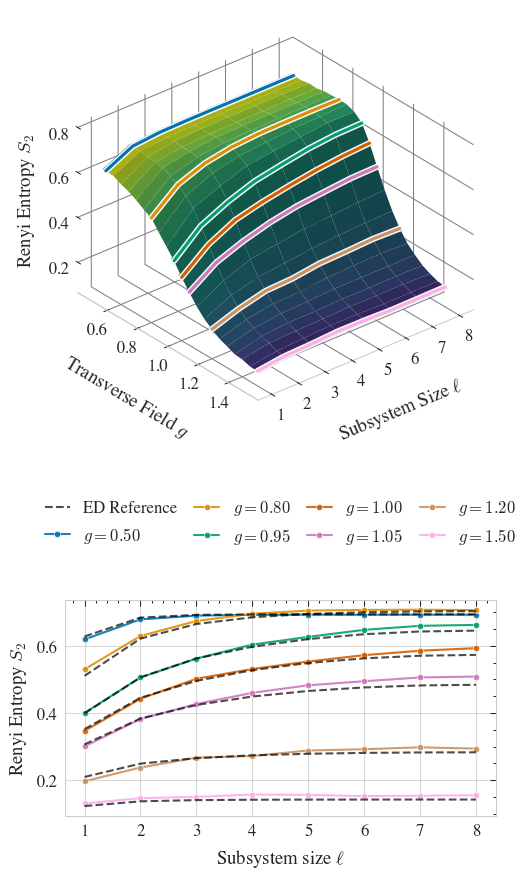

In [11]:
# --- Configuration ---
SAVE_FIG = True
FILENAME = "tfim_4x4_entropy.pdf"
COLUMN_MODE = "single"          # "single" or "double"
SAVE_TIGHT = False              # keep False while tuning

# ==========================================================
# FONT SIZES (separate knobs)
# ==========================================================
TEXT_SIZE = 9                   # axis labels + z-label text
TICK_LABEL_SIZE = 8             # tick numbers (2D + 3D)
LEGEND_SIZE = 8                 # legend text
PANEL_LABEL_SIZE = 12           # (kept for compatibility; panel indices removed)

# ==========================================================
# 3D KNOBS
# ==========================================================
THREE_D_RATIO = 2.0
TWO_D_RATIO   = 1.0

# Vertical spacing between 3D (top) and 2D (bottom)
VERTICAL_GAP = 0.50             # larger -> more separation

SHIFT_3D_X = -0.02              # + right, - left

BOX_ASPECT_X = 1.0
BOX_ASPECT_Y = 1.0
BOX_ASPECT_Z = 0.7

XTICK_PAD = -3                  # apply AFTER draw
YTICK_PAD = -3
ZTICK_PAD = -3

X_LABEL_SPACE = 0.0             # mplot3d private spacing knob
Y_LABEL_SPACE = 0.0
X_LABELPAD = 0
Y_LABELPAD = 0

ZLABEL_X = -0.04                # manual z-label position (axes fraction)
ZLABEL_Y = 0.55
ZLABEL_ROT = 90

# ==========================================================
# 2D KNOBS
# ==========================================================
LEGEND_NCOL = 4
LEGEND_ANCHOR = (0.5, 1.22)     # centered ABOVE the 2D axes
LEGEND_LOC = "lower center"

# ==========================================================
# Figure margins
# ==========================================================
LEFT_MARGIN   = 0.16
RIGHT_MARGIN  = 0.98
TOP_MARGIN    = 0.98
BOTTOM_MARGIN = 0.08

FIELD_SYMBOL = "g"              # display-only symbol (data stays named "h")

def _apply_3d_label_spacing(ax, x_space, y_space, x_pad, y_pad):
    ax.xaxis._axinfo["label"]["space_factor"] = x_space
    ax.yaxis._axinfo["label"]["space_factor"] = y_space
    ax.xaxis.labelpad = x_pad
    ax.yaxis.labelpad = y_pad

with plt.rc_context({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TICK_LABEL_SIZE,
    "ytick.labelsize": TICK_LABEL_SIZE,
    "legend.fontsize": LEGEND_SIZE,
}):
    width = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
    total_height = 6.0 if COLUMN_MODE == "single" else 5.0

    fig = plt.figure(figsize=(width, total_height), dpi=DPI)
    fig.subplots_adjust(left=LEFT_MARGIN, right=RIGHT_MARGIN, top=TOP_MARGIN, bottom=BOTTOM_MARGIN)

    gs = gridspec.GridSpec(
        2, 1,
        height_ratios=[THREE_D_RATIO, TWO_D_RATIO],
        hspace=VERTICAL_GAP
    )

    # ==========================================
    # 1) 3D SURFACE (Top)  -> viridis is fine here
    # ==========================================
    ax3d = fig.add_subplot(gs[0], projection="3d")
    ax3d.set_proj_type("ortho")

    pos = ax3d.get_position()
    ax3d.set_position([pos.x0 + SHIFT_3D_X, pos.y0, pos.width, pos.height])

    ax3d.zaxis._axinfo["juggled"] = (1, 0, 2)

    ax3d.minorticks_off()
    ax3d.xaxis.set_minor_locator(ticker.NullLocator())
    ax3d.yaxis.set_minor_locator(ticker.NullLocator())
    ax3d.zaxis.set_minor_locator(ticker.NullLocator())

    ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.2))

    ax3d.set_box_aspect((BOX_ASPECT_X, BOX_ASPECT_Y, BOX_ASPECT_Z))

    grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
    for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
        axis._axinfo["grid"].update(grid_style)
        axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    cmap_surface = plt.get_cmap("viridis")
    norm_h = mcolors.Normalize(vmin=h_dense.min(), vmax=h_dense.max())

    t = norm_h(X_h)
    t = 1.0 - t
    t = 0.10 + 0.85 * t
    surface_colors = cmap_surface(t)

    ax3d.plot_surface(
        X_h, Y_l, Z_s2,
        facecolors=surface_colors,
        rstride=1, cstride=1,
        shade=True, linewidth=0, alpha=1.0, antialiased=True
    )

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)

    ax3d.set_xlabel(rf"Transverse Field ${FIELD_SYMBOL}$", fontsize=TEXT_SIZE)
    ax3d.set_ylabel(r"Subsystem Size $\ell$", fontsize=TEXT_SIZE)

    ax3d.set_zlabel("")
    zlab = ax3d.text2D(
        ZLABEL_X, ZLABEL_Y, r"Renyi Entropy $S_2$",
        transform=ax3d.transAxes,
        rotation=ZLABEL_ROT, va="center", ha="right",
        fontsize=TEXT_SIZE,
        clip_on=False
    )

    ax3d.view_init(elev=30, azim=-40)

    _apply_3d_label_spacing(ax3d, X_LABEL_SPACE, Y_LABEL_SPACE, X_LABELPAD, Y_LABELPAD)
    fig.canvas.draw()

    for tck in ax3d.xaxis.get_major_ticks():
        tck.set_pad(XTICK_PAD)
    for tck in ax3d.yaxis.get_major_ticks():
        tck.set_pad(YTICK_PAD)
    for tck in ax3d.zaxis.get_major_ticks():
        tck.set_pad(ZTICK_PAD)

    for lab in ax3d.get_xticklabels() + ax3d.get_yticklabels() + ax3d.get_zticklabels():
        lab.set_clip_on(False)
        lab.set_fontsize(TICK_LABEL_SIZE)

    fig.canvas.draw()

    # ==========================================
    # 2) 2D CUTS (Bottom) + overlays on 3D
    # colors picked in order of h (sorted)
    # ==========================================
    ax2d = fig.add_subplot(gs[1])

    palette_2d = SB_COLORBLIND
    H_RIBBON_PAD = 0.02

    # sort h and assign colors in that order
    h_sorted = sorted([float(h) for h in support_h_keys])
    h_to_color = {h0: palette_2d[i % len(palette_2d)] for i, h0 in enumerate(h_sorted)}

    ref_label_added = False

    for h0 in h_sorted:
        subset = df_res[df_res["h"] == h0].sort_values("l")
        s2_vals = subset["s2"].values
        color = h_to_color[h0]

        # --- ribbon surface on 3D (use SB color) ---
        h_left  = h0 - H_RIBBON_PAD
        h_right = h0 + H_RIBBON_PAD

        X_rib = np.vstack([
            np.full_like(l_values, h_left, dtype=float),
            np.full_like(l_values, h_right, dtype=float),
        ])
        Y_rib = np.vstack([l_values, l_values])
        Z_rib = np.vstack([s2_vals, s2_vals])

        ax3d.plot_surface(
            X_rib, Y_rib, Z_rib,
            color=color, shade=True, linewidth=0, alpha=1.0, antialiased=True
        )

        # --- 3D cut line (white underlay + SB overlay) ---
        xline = np.full_like(l_values, h0, dtype=float)

        ax3d.plot(
            xline, l_values, s2_vals,
            color="white", linestyle="-", linewidth=3.0, alpha=0.95,
            solid_capstyle="round", solid_joinstyle="round", zorder=19
        )
        ax3d.plot(
            xline, l_values, s2_vals,
            color=color, linestyle="-", linewidth=1.5, alpha=1.0,
            solid_capstyle="round", solid_joinstyle="round", zorder=20
        )

        # --- ED reference (2D) ---
        if not ref_df_2.empty:
            mask = np.isclose(ref_df_2["h"].values, h0, atol=1e-6)
            if mask.any():
                row = ref_df_2.loc[mask].iloc[0]
                x_ref, y_ref = [], []
                for c in ref_df_2.columns:
                    if c.startswith("l"):
                        ell = int(c[1:])
                        if ell in l_values:
                            x_ref.append(ell)
                            y_ref.append(row[c])

                # sort reference points by ell
                x_ref = np.asarray(x_ref, dtype=int)
                y_ref = np.asarray(y_ref, dtype=float)
                order = np.argsort(x_ref)

                lbl = ref_style["label"] if not ref_label_added else "_nolegend_"
                style_kwargs = ref_style.copy()
                style_kwargs["label"] = lbl
                ax2d.plot(x_ref[order], y_ref[order], **style_kwargs, zorder=5)
                ref_label_added = True

        # --- model curve (2D) ---
        ax2d.plot(
            l_values, s2_vals,
            marker="o", linestyle="-", color=color, markersize=3,
            linewidth=1.0, alpha=0.9,
            markeredgecolor="white", markeredgewidth=0.3,
            label=rf"${FIELD_SYMBOL}={h0:.2f}$",
            zorder=4
        )

        # (no error shadows)

    ax2d.set_xlabel(r"Subsystem size $\ell$", fontsize=TEXT_SIZE)
    ax2d.set_ylabel(r"Renyi Entropy $S_2$", fontsize=TEXT_SIZE)

    # force integer ℓ ticks
    ax2d.xaxis.set_major_locator(mticker.MultipleLocator(1))

    ax2d.grid(True, which="major", alpha=0.3, color="gray", linewidth=0.5)

    for lab in ax2d.get_xticklabels() + ax2d.get_yticklabels():
        lab.set_fontsize(TICK_LABEL_SIZE)

    leg = ax2d.legend(
        frameon=False,
        fontsize=LEGEND_SIZE,
        ncol=LEGEND_NCOL,
        loc=LEGEND_LOC,
        bbox_to_anchor=LEGEND_ANCHOR,
        columnspacing=1.0,
        handlelength=1.5,
        borderaxespad=0.0
    )

    if SAVE_FIG:
        if SAVE_TIGHT:
            fig.savefig(FILENAME, bbox_inches="tight", pad_inches=0.02, bbox_extra_artists=[zlab, leg])
        else:
            fig.savefig(FILENAME)
        print(f"Saved: {FILENAME}")

    plt.show()


Saved: tfim_4x4_entropy_2d.pdf


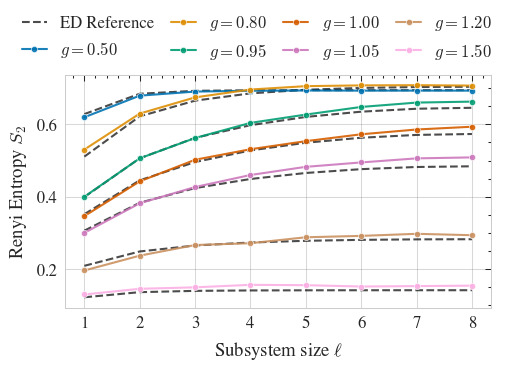

In [23]:
# =========================
# Cell - Entropy cuts (2D only)
# =========================
SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_2d.pdf"
COLUMN_MODE = "single"
FIELD_SYMBOL = "g"  # display-only (data column stays "h")

# --- FIGURE HEIGHT ---
# Pick this so that AFTER bbox_inches="tight" (including the legend) the output height
# matches your other figures (e.g. overlap-vs-g).
FIG_HEIGHT_RATIO = 0.75   # tune: 0.55..0.70 (0.75 would be "axes only" without legend above)

# --- LEGEND POSITION (two handles you can tune) ---
LEGEND_ANCHOR_X = 0.45
LEGEND_ANCHOR_Y = 1.03

# --- legend style ---
LEGEND_NCOL = 4
LEGEND_LOC  = "lower center"

# --- font sizes ---
TEXT_SIZE       = 9
TICK_LABEL_SIZE = 8
LEGEND_SIZE     = 8

# --- margins (keep simple; tight_layout + bbox_inches does the rest) ---
LEFT_MARGIN   = 0.16
RIGHT_MARGIN  = 0.98
TOP_MARGIN    = 0.98
BOTTOM_MARGIN = 0.12

with plt.rc_context({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TICK_LABEL_SIZE,
    "ytick.labelsize": TICK_LABEL_SIZE,
    "legend.fontsize": LEGEND_SIZE,
}):
    width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
    height = width * FIG_HEIGHT_RATIO

    fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)
    fig.subplots_adjust(left=LEFT_MARGIN, right=RIGHT_MARGIN, top=TOP_MARGIN, bottom=BOTTOM_MARGIN)

    # colors picked in order of h (sorted)
    h_sorted = sorted([float(h) for h in support_h_keys])
    palette  = SB_COLORBLIND
    h_to_color = {h0: palette[i % len(palette)] for i, h0 in enumerate(h_sorted)}

    ref_label_added = False

    for h0 in h_sorted:
        subset = df_res[df_res["h"] == h0].sort_values("l")
        ell    = subset["l"].values
        s2     = subset["s2"].values
        color  = h_to_color[h0]

        # --- ED reference curve (if available) ---
        if (ref_df_2 is not None) and (not ref_df_2.empty):
            mask = np.isclose(ref_df_2["h"].values, h0, atol=1e-6)
            if mask.any():
                row = ref_df_2.loc[mask].iloc[0]
                x_ref, y_ref = [], []
                for c in ref_df_2.columns:
                    if c.startswith("l"):
                        ell_c = int(c[1:])
                        if ell_c in set(np.asarray(l_values, dtype=int).tolist()):
                            x_ref.append(ell_c)
                            y_ref.append(float(row[c]))

                if len(x_ref) > 0:
                    x_ref = np.asarray(x_ref, dtype=int)
                    y_ref = np.asarray(y_ref, dtype=float)
                    order = np.argsort(x_ref)

                    style_kwargs = ref_style.copy()
                    style_kwargs["label"] = style_kwargs["label"] if not ref_label_added else "_nolegend_"
                    ax.plot(x_ref[order], y_ref[order], **style_kwargs, zorder=2)
                    ref_label_added = True

        # --- model curve (NO error bands) ---
        ax.plot(
            ell, s2,
            color=color,
            linestyle=main_style.get("linestyle", "-"),
            linewidth=main_style.get("linewidth", 1.0),
            alpha=main_style.get("alpha", 0.9),
            marker="o",
            markersize=3,
            markeredgecolor="white",
            markeredgewidth=0.3,
            label=rf"${FIELD_SYMBOL}={h0:.2f}$",
            zorder=3,
        )

    ax.set_xlabel(r"Subsystem size $\ell$")
    ax.set_ylabel(r"Renyi Entropy $S_2$")

    # integer ticks on ℓ
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

    ax.grid(True, which="major", alpha=0.3, color="gray", linewidth=0.5)

    leg = ax.legend(
        frameon=False,
        fontsize=LEGEND_SIZE,
        ncol=LEGEND_NCOL,
        loc=LEGEND_LOC,
        bbox_to_anchor=(LEGEND_ANCHOR_X, LEGEND_ANCHOR_Y),
        columnspacing=1.0,
        handlelength=1.5,
        borderaxespad=0.0,
    )

    fig.tight_layout()

    if SAVE_FIG:
        fig.savefig(FILENAME, bbox_inches="tight", bbox_extra_artists=[leg])
        print(f"Saved: {FILENAME}")

    plt.show()


Saved: tfim_4x4_entropy_2d.pdf


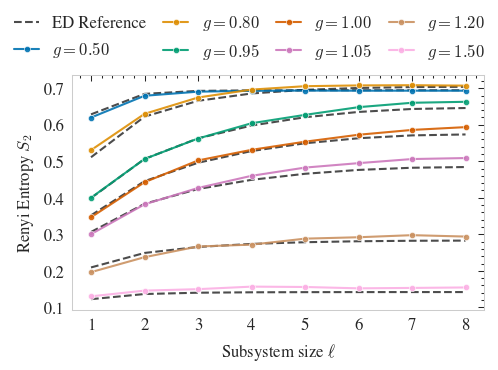

In [25]:
# =========================
# Cell - Entropy cuts (2D only)
# =========================
SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_2d.pdf"
COLUMN_MODE = "single"
FIELD_SYMBOL = "g"  # display-only (data column stays "h")

# figure size (same convention as overlap-vs-g)
FIG_HEIGHT_RATIO = 0.75
width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO

# legend placement knobs (like you wanted)
LEGEND_ANCHOR_X = 0.43
LEGEND_ANCHOR_Y = 1.03
LEGEND_NCOL     = 4
LEGEND_LOC      = "lower center"

fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

# colors picked in order of h (sorted)
h_sorted = sorted([float(h) for h in support_h_keys])
colors   = SB_COLORBLIND
h_to_color = {h0: colors[i % len(colors)] for i, h0 in enumerate(h_sorted)}

ref_label_added = False

for h0 in h_sorted:
    subset = df_res[df_res["h"] == h0].sort_values("l")
    ell = subset["l"].values
    s2  = subset["s2"].values
    color = h_to_color[h0]

    # ED reference curve (if available)
    if (ref_df_2 is not None) and (not ref_df_2.empty):
        mask = np.isclose(ref_df_2["h"].values, h0, atol=1e-6)
        if mask.any():
            row = ref_df_2.loc[mask].iloc[0]

            x_ref, y_ref = [], []
            for c in ref_df_2.columns:
                if c.startswith("l"):
                    x_ref.append(int(c[1:]))
                    y_ref.append(float(row[c]))

            if x_ref:
                x_ref = np.asarray(x_ref, dtype=int)
                y_ref = np.asarray(y_ref, dtype=float)
                order = np.argsort(x_ref)

                style_kwargs = ref_style.copy()
                style_kwargs["label"] = style_kwargs["label"] if not ref_label_added else "_nolegend_"
                ax.plot(x_ref[order], y_ref[order], **style_kwargs, zorder=2)
                ref_label_added = True

    # model curve (NO error bands)
    ax.plot(
        ell, s2,
        color=color,
        label=rf"${FIELD_SYMBOL}={h0:.2f}$",
        linestyle=main_style.get("linestyle", "-"),
        linewidth=main_style.get("linewidth", 1.0),
        alpha=main_style.get("alpha", 0.9),
        marker=main_style.get("marker", "o"),
        markersize=main_style.get("markersize", 3),
        markeredgecolor="white",
        markeredgewidth=0.3,
        zorder=3,
    )

ax.set_xlabel(r"Subsystem size $\ell$")
ax.set_ylabel(r"Renyi Entropy $S_2$")

# integer ticks on ℓ
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

# match your overlap plot styling
ax.grid(False)

leg = ax.legend(
    frameon=False,
    ncol=LEGEND_NCOL,
    loc=LEGEND_LOC,
    bbox_to_anchor=(LEGEND_ANCHOR_X, LEGEND_ANCHOR_Y),
    columnspacing=1.0,
    handlelength=1.5,
    borderaxespad=0.0,
)

fig.tight_layout()

if SAVE_FIG:
    fig.savefig(FILENAME, bbox_inches="tight", bbox_extra_artists=[leg])
    print(f"Saved: {FILENAME}")

plt.show()


Saved: tfim_4x4_entropy_2d.pdf


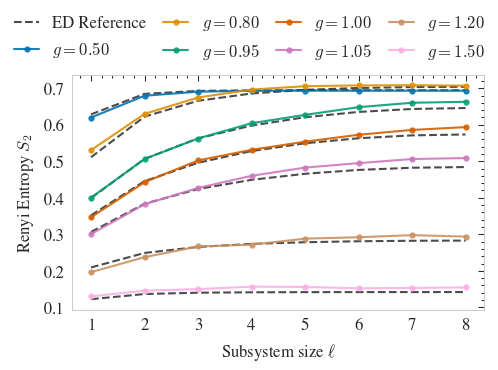

In [26]:
# =========================
# Cell - Entropy cuts (2D only)
# =========================
SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_2d.pdf"
COLUMN_MODE = "single"
FIELD_SYMBOL = "g"  # display-only (data column stays "h")

# figure size (same convention as overlap-vs-g)
FIG_HEIGHT_RATIO = 0.75
width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO

# legend placement knobs
LEGEND_ANCHOR_X = 0.43
LEGEND_ANCHOR_Y = 1.03
LEGEND_NCOL     = 4
LEGEND_LOC      = "lower center"

# force circle markers + match line style to main_style
MARKER_SHAPE = "o"
MARKER_SIZE  = main_style.get("markersize", 3)
LINESTYLE    = main_style.get("linestyle", "-")
LINEWIDTH    = main_style.get("linewidth", 1.0)
LINEALPHA    = main_style.get("alpha", 0.9)

fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

# colors picked in order of h (sorted)
h_sorted = sorted([float(h) for h in support_h_keys])
colors   = SB_COLORBLIND
h_to_color = {h0: colors[i % len(colors)] for i, h0 in enumerate(h_sorted)}

ref_label_added = False

for h0 in h_sorted:
    subset = df_res[df_res["h"] == h0].sort_values("l")
    ell = subset["l"].values
    s2  = subset["s2"].values
    color = h_to_color[h0]

    # ED reference curve (if available)
    if (ref_df_2 is not None) and (not ref_df_2.empty):
        mask = np.isclose(ref_df_2["h"].values, h0, atol=1e-6)
        if mask.any():
            row = ref_df_2.loc[mask].iloc[0]

            x_ref, y_ref = [], []
            for c in ref_df_2.columns:
                if c.startswith("l"):
                    x_ref.append(int(c[1:]))
                    y_ref.append(float(row[c]))

            if x_ref:
                x_ref = np.asarray(x_ref, dtype=int)
                y_ref = np.asarray(y_ref, dtype=float)
                order = np.argsort(x_ref)

                style_kwargs = ref_style.copy()
                style_kwargs["label"] = style_kwargs["label"] if not ref_label_added else "_nolegend_"
                ax.plot(x_ref[order], y_ref[order], **style_kwargs, zorder=2)
                ref_label_added = True

    # model curve (NO error bands) - circles, same line styling as main_style
    ax.plot(
        ell, s2,
        color=color,
        label=rf"${FIELD_SYMBOL}={h0:.2f}$",
        linestyle=LINESTYLE,
        linewidth=LINEWIDTH,
        alpha=LINEALPHA,
        marker=MARKER_SHAPE,
        markersize=MARKER_SIZE,
        markerfacecolor=color,
        markeredgewidth=0.0,
        zorder=3,
    )

ax.set_xlabel(r"Subsystem size $\ell$")
ax.set_ylabel(r"Renyi Entropy $S_2$")

# integer ticks on ℓ
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

# match your overlap plot styling
ax.grid(False)

leg = ax.legend(
    frameon=False,
    ncol=LEGEND_NCOL,
    loc=LEGEND_LOC,
    bbox_to_anchor=(LEGEND_ANCHOR_X, LEGEND_ANCHOR_Y),
    columnspacing=1.0,
    handlelength=1.5,
    borderaxespad=0.0,
)

fig.tight_layout()

if SAVE_FIG:
    fig.savefig(FILENAME, bbox_inches="tight", bbox_extra_artists=[leg])
    print(f"Saved: {FILENAME}")

plt.show()


Saved: tfim_4x4_entropy_2d.pdf


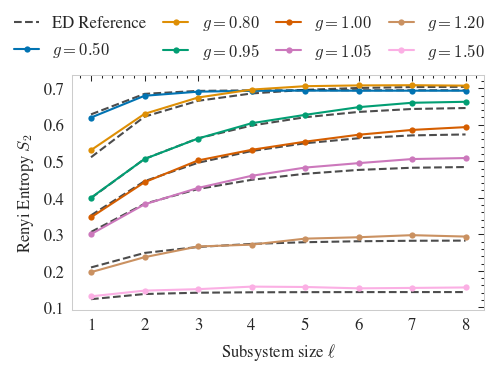

In [27]:
# =========================
# Cell - Entropy cuts (2D only)
# =========================
SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_2d.pdf"
COLUMN_MODE = "single"
FIELD_SYMBOL = "g"  # display-only (data column stays "h")

# figure size (same convention as overlap-vs-g)
FIG_HEIGHT_RATIO = 0.75
width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO

# legend placement knobs
LEGEND_ANCHOR_X = 0.43
LEGEND_ANCHOR_Y = 1.03
LEGEND_NCOL     = 4
LEGEND_LOC      = "lower center"

# enforce: filled circles + line thickness comparable to ED reference
MARKER_SHAPE = "o"
MARKER_SIZE  = main_style.get("markersize", 3)
LINESTYLE    = main_style.get("linestyle", "-")
LINEWIDTH    = ref_style.get("linewidth", main_style.get("linewidth", 1.0))  # match ED thickness
LINEALPHA    = 1.0  # avoid any "looks thinner" effect

fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

# colors picked in order of h (sorted)
h_sorted = sorted([float(h) for h in support_h_keys])
colors   = SB_COLORBLIND
h_to_color = {h0: colors[i % len(colors)] for i, h0 in enumerate(h_sorted)}

ref_label_added = False

for h0 in h_sorted:
    subset = df_res[df_res["h"] == h0].sort_values("l")
    ell = subset["l"].values
    s2  = subset["s2"].values
    color = h_to_color[h0]

    # ED reference curve (if available)
    if (ref_df_2 is not None) and (not ref_df_2.empty):
        mask = np.isclose(ref_df_2["h"].values, h0, atol=1e-6)
        if mask.any():
            row = ref_df_2.loc[mask].iloc[0]

            x_ref, y_ref = [], []
            for c in ref_df_2.columns:
                if c.startswith("l"):
                    x_ref.append(int(c[1:]))
                    y_ref.append(float(row[c]))

            if x_ref:
                x_ref = np.asarray(x_ref, dtype=int)
                y_ref = np.asarray(y_ref, dtype=float)
                order = np.argsort(x_ref)

                style_kwargs = ref_style.copy()
                style_kwargs["label"] = style_kwargs["label"] if not ref_label_added else "_nolegend_"
                ax.plot(x_ref[order], y_ref[order], **style_kwargs, zorder=2)
                ref_label_added = True

    # model curve (NO error bands) - FILLED circles
    ax.plot(
        ell, s2,
        color=color,
        label=rf"${FIELD_SYMBOL}={h0:.2f}$",
        linestyle=LINESTYLE,
        linewidth=LINEWIDTH,
        alpha=LINEALPHA,
        marker=MARKER_SHAPE,
        markersize=MARKER_SIZE,
        fillstyle="full",
        markerfacecolor=color,
        markeredgecolor=color,
        markeredgewidth=0.0,
        zorder=3,
    )

ax.set_xlabel(r"Subsystem size $\ell$")
ax.set_ylabel(r"Renyi Entropy $S_2$")

# integer ticks on ℓ
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

# match your overlap plot styling
ax.grid(False)

leg = ax.legend(
    frameon=False,
    ncol=LEGEND_NCOL,
    loc=LEGEND_LOC,
    bbox_to_anchor=(LEGEND_ANCHOR_X, LEGEND_ANCHOR_Y),
    columnspacing=1.0,
    handlelength=1.5,
    borderaxespad=0.0,
)

fig.tight_layout()

if SAVE_FIG:
    fig.savefig(FILENAME, bbox_inches="tight", bbox_extra_artists=[leg])
    print(f"Saved: {FILENAME}")

plt.show()

In [10]:
# =========================
# Legend block (like screenshot)
# =========================

LEGEND_NCOL   = 4
LEGEND_LOC    = "lower center"
LEGEND_ANCHOR = (0.5, 1.28)   # move up/down as needed
LEGEND_SIZE   = 8

# You must have a mapping g -> color used in the plot, e.g.:
# g_to_color = {0.50: SB_COLORBLIND[0], 0.80: SB_COLORBLIND[1], ...}

row1 = [0.80, 1.00, 1.20]
row2 = [0.50, 0.95, 1.05, 1.50]

# Matplotlib is column-major; this ordering makes it *appear* row-major.
g_order_for_legend = [row2[0], row1[0], row2[1], row1[1], row2[2], row1[2], row2[3]]

handles = []

# ED reference proxy
_ed = ref_style.copy()
_ed["label"] = "ED Reference"
handles.append(Line2D([0], [0], **_ed))

# g proxies
for g0 in g_order_for_legend:
    handles.append(Line2D(
        [0], [0],
        color=g_to_color[g0],
        linestyle=main_style.get("linestyle", "-"),
        linewidth=main_style.get("linewidth", 1.0),
        marker=main_style.get("marker", "o"),
        markersize=main_style.get("markersize", 3),
        markeredgecolor="white",
        markeredgewidth=0.3,
        label=rf"$g={g0:.2f}$",
    ))

leg = ax.legend(
    handles=handles,
    ncol=LEGEND_NCOL,
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_ANCHOR,
    frameon=False,
    fontsize=LEGEND_SIZE,
    columnspacing=1.2,
    handlelength=2.0,
    handletextpad=0.6,
    borderaxespad=0.0,
    labelspacing=0.6,
)


NameError: name 'g_to_color' is not defined

Saved: tfim_4x4_entropy_3d.pdf


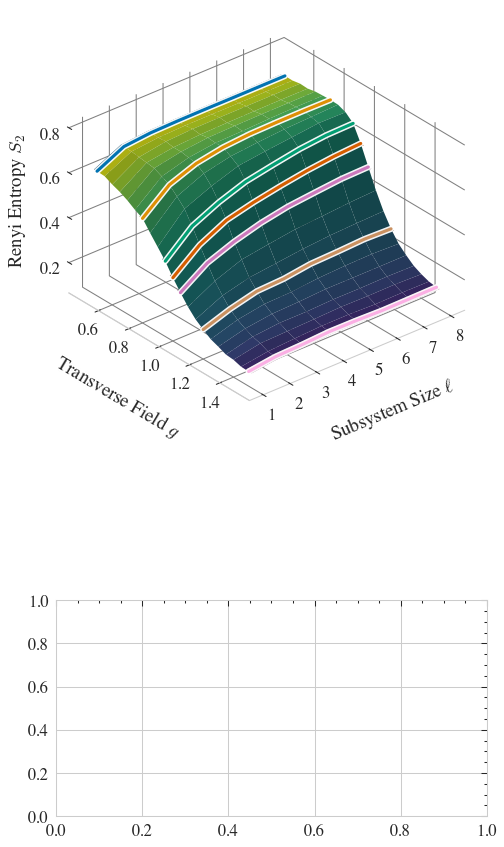

In [7]:
# --- Configuration ---
SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_3d.pdf"
COLUMN_MODE = "single"          # "single" or "double"
SAVE_TIGHT = False              # keep False while tuning

# ==========================================================
# FONT SIZES (separate knobs)
# ==========================================================
TEXT_SIZE = 9                   # axis labels + z-label text
TICK_LABEL_SIZE = 8             # tick numbers (2D + 3D)
LEGEND_SIZE = 8                 # legend text
PANEL_LABEL_SIZE = 12           # (kept for compatibility; panel indices removed)

# ==========================================================
# 3D KNOBS
# ==========================================================
THREE_D_RATIO = 2.0
TWO_D_RATIO   = 1.0

# Vertical spacing between 3D (top) and 2D (bottom)
VERTICAL_GAP = 0.50             # larger -> more separation

SHIFT_3D_X = -0.02              # + right, - left

BOX_ASPECT_X = 1.0
BOX_ASPECT_Y = 1.0
BOX_ASPECT_Z = 0.7

XTICK_PAD = -3                  # apply AFTER draw
YTICK_PAD = -3
ZTICK_PAD = -3

X_LABEL_SPACE = 0.0             # mplot3d private spacing knob
Y_LABEL_SPACE = 0.0
X_LABELPAD = 0
Y_LABELPAD = 0

ZLABEL_X = -0.04                # manual z-label position (axes fraction)
ZLABEL_Y = 0.55
ZLABEL_ROT = 90

# ==========================================================
# 3D Plot Setup
# ==========================================================
with plt.rc_context({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TICK_LABEL_SIZE,
    "ytick.labelsize": TICK_LABEL_SIZE,
    "legend.fontsize": LEGEND_SIZE,
}):
    width = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
    total_height = 6.0 if COLUMN_MODE == "single" else 5.0

    fig = plt.figure(figsize=(width, total_height), dpi=DPI)
    fig.subplots_adjust(left=LEFT_MARGIN, right=RIGHT_MARGIN, top=TOP_MARGIN, bottom=BOTTOM_MARGIN)

    gs = gridspec.GridSpec(
        2, 1,
        height_ratios=[THREE_D_RATIO, TWO_D_RATIO],
        hspace=VERTICAL_GAP
    )

    # ==========================================
    # 1) 3D SURFACE (Top) -> viridis is fine here
    # ==========================================
    ax3d = fig.add_subplot(gs[0], projection="3d")
    ax3d.set_proj_type("ortho")

    pos = ax3d.get_position()
    ax3d.set_position([pos.x0 + SHIFT_3D_X, pos.y0, pos.width, pos.height])

    ax3d.zaxis._axinfo["juggled"] = (1, 0, 2)

    ax3d.minorticks_off()
    ax3d.xaxis.set_minor_locator(ticker.NullLocator())
    ax3d.yaxis.set_minor_locator(ticker.NullLocator())
    ax3d.zaxis.set_minor_locator(ticker.NullLocator())

    ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.2))

    ax3d.set_box_aspect((BOX_ASPECT_X, BOX_ASPECT_Y, BOX_ASPECT_Z))

    grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
    for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
        axis._axinfo["grid"].update(grid_style)
        axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    cmap_surface = plt.get_cmap("viridis")
    norm_h = mcolors.Normalize(vmin=h_dense.min(), vmax=h_dense.max())

    t = norm_h(X_h)
    t = 1.0 - t
    t = 0.10 + 0.85 * t
    surface_colors = cmap_surface(t)

    ax3d.plot_surface(
        X_h, Y_l, Z_s2,
        facecolors=surface_colors,
        rstride=1, cstride=1,
        shade=True, linewidth=0, alpha=1.0, antialiased=True
    )

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)

    ax3d.set_xlabel(rf"Transverse Field ${FIELD_SYMBOL}$", fontsize=TEXT_SIZE)
    ax3d.set_ylabel(r"Subsystem Size $\ell$", fontsize=TEXT_SIZE)

    ax3d.set_zlabel("")
    zlab = ax3d.text2D(
        ZLABEL_X, ZLABEL_Y, r"Renyi Entropy $S_2$",
        transform=ax3d.transAxes,
        rotation=ZLABEL_ROT, va="center", ha="right",
        fontsize=TEXT_SIZE,
        clip_on=False
    )

    ax3d.view_init(elev=30, azim=-40)

    _apply_3d_label_spacing(ax3d, X_LABEL_SPACE, Y_LABEL_SPACE, X_LABELPAD, Y_LABELPAD)
    fig.canvas.draw()

    for tck in ax3d.xaxis.get_major_ticks():
        tck.set_pad(XTICK_PAD)
    for tck in ax3d.yaxis.get_major_ticks():
        tck.set_pad(YTICK_PAD)
    for tck in ax3d.zaxis.get_major_ticks():
        tck.set_pad(ZTICK_PAD)

    for lab in ax3d.get_xticklabels() + ax3d.get_yticklabels() + ax3d.get_zticklabels():
        lab.set_clip_on(False)
        lab.set_fontsize(TICK_LABEL_SIZE)

    fig.canvas.draw()

    # ==========================================
    # 2) 2D CUTS (Bottom) + overlays on 3D -> SB_COLORBLIND
    # ==========================================
    ax2d = fig.add_subplot(gs[1])

    ref_label_added = False
    H_RIBBON_PAD = 0.02

    for i, h in enumerate(support_h_keys):
        h0 = float(h)
        subset = df_res[df_res["h"] == h].sort_values("l")
        s2_vals = subset["s2"].values
        err_vals = subset["s2_err"].values

        color = palette_2d[i % len(palette_2d)]

        # --- ribbon surface on 3D ---
        h_left  = h0 - H_RIBBON_PAD
        h_right = h0 + H_RIBBON_PAD

        X_rib = np.vstack([
            np.full_like(l_values, h_left, dtype=float),
            np.full_like(l_values, h_right, dtype=float),
        ])
        Y_rib = np.vstack([l_values, l_values])
        Z_rib = np.vstack([s2_vals, s2_vals])

        ax3d.plot_surface(
            X_rib, Y_rib, Z_rib,
            color=color, shade=True, linewidth=0, alpha=1.0, antialiased=True
        )

        # --- 3D cut line (white underlay + colored overlay) ---
        xline = np.full_like(l_values, h0, dtype=float)

        ax3d.plot(
            xline, l_values, s2_vals,
            color="white", linestyle="-", linewidth=3.0, alpha=0.95,
            solid_capstyle="round", solid_joinstyle="round", zorder=19
        )
        ax3d.plot(
            xline, l_values, s2_vals,
            color=color, linestyle="-", linewidth=1.5, alpha=1.0,
            solid_capstyle="round", solid_joinstyle="round", zorder=20
        )

    if SAVE_FIG:
        if SAVE_TIGHT:
            fig.savefig(FILENAME, bbox_inches="tight", pad_inches=0.02)
        else:
            fig.savefig(FILENAME)
        print(f"Saved: {FILENAME}")

    plt.show()
